In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from scipy.stats import pearsonr
from fastdtw import fastdtw

# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key
# Retrieve alpha vantage api_key
with open('config.json', 'r') as config_file:
            config_data = json.load(config_file)
            api_key =  config_data.get('alpha_vantage_api_key')
BASE_URL = 'https://www.alphavantage.co/query'

In [2]:
def fetch_data(symbol, function, **params):
    params['function'] = function
    params['symbol'] = symbol
    params['apikey'] = api_key
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    return data

In [3]:
def symbol_data_to_data_frame(data):
    df = pd.DataFrame(data).T
    df.index = pd.to_datetime(df.index)
    df['5. adjusted close'] = df['5. adjusted close'].astype(float)
    return df

In [4]:
def line_plot_symbol_df(df, titel, x, y):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['5. adjusted close'])
    plt.title(titel)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.show()

In [5]:
# List of sector symbols
sectors = [
    "XLC",  # Communication Services
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLF",  # Financials
    "XLV",  # Health Care
    "XLI",  # Industrials
    "XLB",  # Materials
    "XLRE", # Real Estate
    "XLK",  # Technology
    "XLU",  # Utilities
]

sectors_dict =	{
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities"
}

sectors_with_name = [
    "Financials", # Financials
    "Real Estate", # Real Estate 
    "Utilities",  # Utilities
    "Consumer Staples",  # Consumer Staples
    "Materials",  # Materials
    "Energy",  # Energy
    "Industrials",  # Industrials
    "Technology",  # Technology
    "Communication Services",  # Communication Services
    "Health Care",  # Health Care
    "Consumer Discretionary",  # Consumer Discretionary 
]

In [6]:
def fetch_sector_data():
    # Dictionary to store sector data
    sector_data = {}

    #non-premium couter
    i = 0

    # Loop through sectors and make API requests
    for sector in sectors:
        data = fetch_data(sector, "TIME_SERIES_MONTHLY_ADJUSTED" )
        if len(data) > 1:
            sector_data[sector] = data['Monthly Adjusted Time Series']
        else:
            #exception for data fetch error
            raise Exception("data fetch error" + ' ' + data['Note'])
        #non-premium delay
        i += 1
        if i == 5:
            time.sleep(60)
            i=0
    return sector_data
sector_data = fetch_sector_data()

{'XLC': {'2023-09-15': {'1. open': '67.9500', '2. high': '68.5100', '3. low': '66.2700', '4. close': '67.5100', '5. adjusted close': '67.5100', '6. volume': '54714094', '7. dividend amount': '0.0000'}, '2023-08-31': {'1. open': '68.4200', '2. high': '68.9200', '3. low': '64.3150', '4. close': '67.7300', '5. adjusted close': '67.7300', '6. volume': '121411440', '7. dividend amount': '0.0000'}, '2023-07-31': {'1. open': '64.8700', '2. high': '69.2200', '3. low': '64.5250', '4. close': '68.7900', '5. adjusted close': '68.7900', '6. volume': '124113723', '7. dividend amount': '0.0000'}, '2023-06-30': {'1. open': '62.4200', '2. high': '65.6100', '3. low': '62.2800', '4. close': '65.0800', '5. adjusted close': '65.0800', '6. volume': '123494649', '7. dividend amount': '0.1049'}, '2023-05-31': {'1. open': '59.8100', '2. high': '62.7200', '3. low': '57.4300', '4. close': '62.2400', '5. adjusted close': '62.1387', '6. volume': '136868565', '7. dividend amount': '0.0000'}, '2023-04-28': {'1. ope

In [7]:
# Convert sector data to pandas DataFrames
def sector_to_data_frame():
    sector_dfs = {}
    for sector, data in sector_data.items():
        df = pd.DataFrame(data).T
        df.index = pd.to_datetime(df.index)
        df['5. adjusted close'] = df['5. adjusted close'].astype(float)
        sector_dfs[sector] = df#.head(15)  # Extract the first 15 rows
    return sector_dfs

sector_dfs = sector_to_data_frame()

{'XLC':             1. open  2. high   3. low 4. close  5. adjusted close  6. volume  \
2023-09-15  67.9500  68.5100  66.2700  67.5100            67.5100   54714094   
2023-08-31  68.4200  68.9200  64.3150  67.7300            67.7300  121411440   
2023-07-31  64.8700  69.2200  64.5250  68.7900            68.7900  124113723   
2023-06-30  62.4200  65.6100  62.2800  65.0800            65.0800  123494649   
2023-05-31  59.8100  62.7200  57.4300  62.2400            62.1387  136868565   
...             ...      ...      ...      ...                ...        ...   
2018-11-30  46.1900  46.7900  42.3800  45.0100            43.1670   53149541   
2018-10-31  49.1700  49.2200  43.0700  46.0400            44.1548  115192982   
2018-09-28  49.0500  49.5300  47.1700  49.0000            46.9936   44621850   
2018-08-31  48.5600  50.0600  47.9000  49.1800            47.0387    6752829   
2018-07-31  49.1100  52.1100  47.8690  48.4600            46.3500    8147373   

           7. dividend amount  

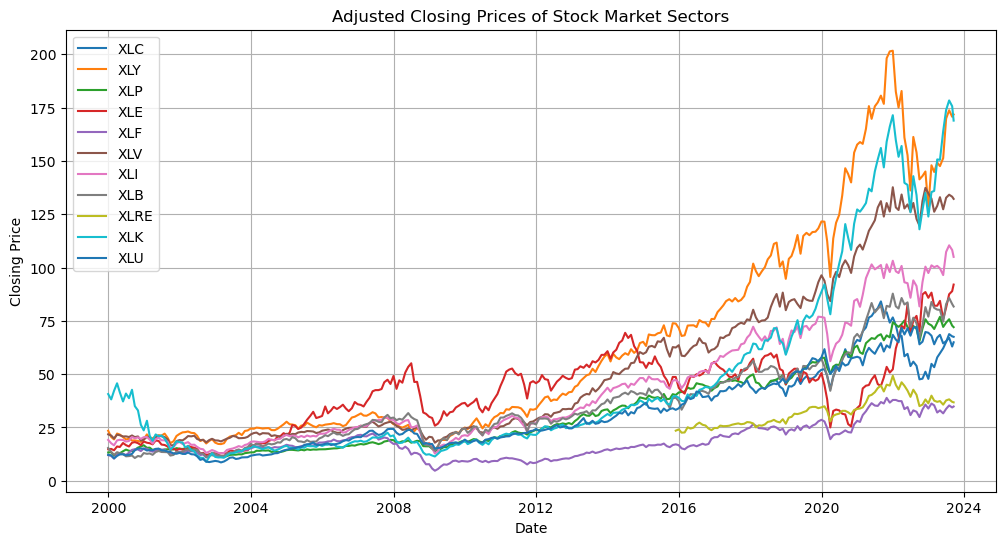

In [8]:
# Create a line plot for each sector's adjusted close values
def line_plot_sectors():
    plt.figure(figsize=(12, 6))
    for sector, df in sector_dfs.items():
        plt.plot(df.index, df['5. adjusted close'], label=sector)

    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title("Adjusted Closing Prices of Stock Market Sectors")
    plt.legend()
    plt.grid(True)
    plt.show()

line_plot_sectors()

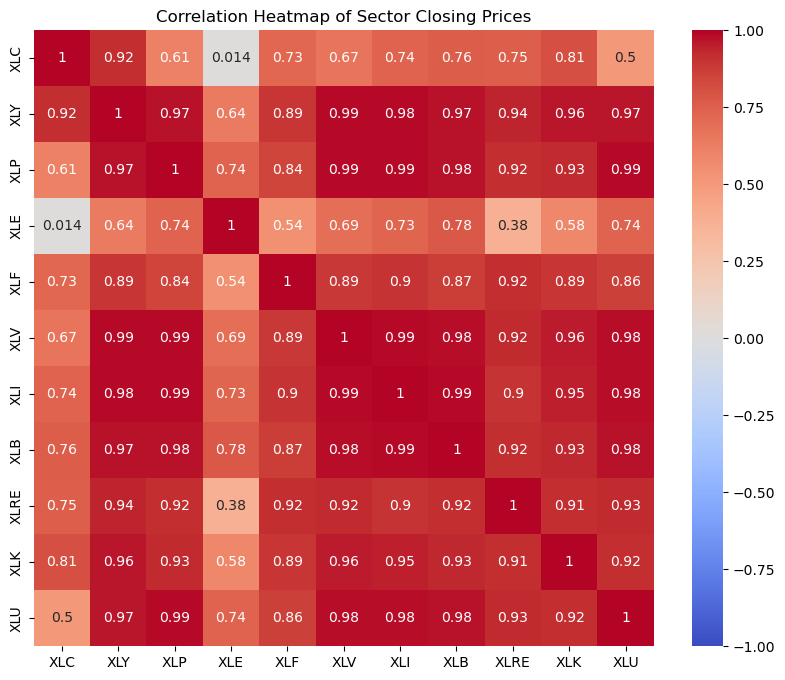

In [9]:
def heatmap_sectors():  
    # Combine the opening prices into a single DataFrame
    combined_df = pd.concat([df["5. adjusted close"] for df in sector_dfs.values()], axis=1)
    combined_df.columns = sectors

    # Calculate the correlation matrix
    correlation_matrix = combined_df.corr()

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap of Sector Closing Prices")
    plt.show()
    
heatmap_sectors()

In [15]:
combined_df = pd.concat([df["5. adjusted close"] for df in sector_dfs.values()], axis=1)
# Get sectors as columns
combined_df.columns = sectors
combined_df = combined_df.fillna(method='bfill')
# Get correlation values for symbols to each other
corrletion_df = combined_df.corr()
# Now took the average mean correlation for each sector
corrletion_df = corrletion_df.mean().sort_values()
# ... and rename the columns
corrletion_df = corrletion_df.reset_index()
corrletion_df.rename(columns={'index': 'sector'}, inplace=True)
corrletion_df.columns.values[1] = 'correlation'

   sector  correlation
0     XLE     0.657840
1     XLC     0.712864
2     XLF     0.844714
3    XLRE     0.862566
4     XLK     0.899190
5     XLU     0.902772
6     XLP     0.903550
7     XLV     0.914805
8     XLY     0.915366
9     XLB     0.915860
10    XLI     0.917650


## Now let's investigate Which sector correlates the best with all others and thus is the best indicator for changes in other sectors.

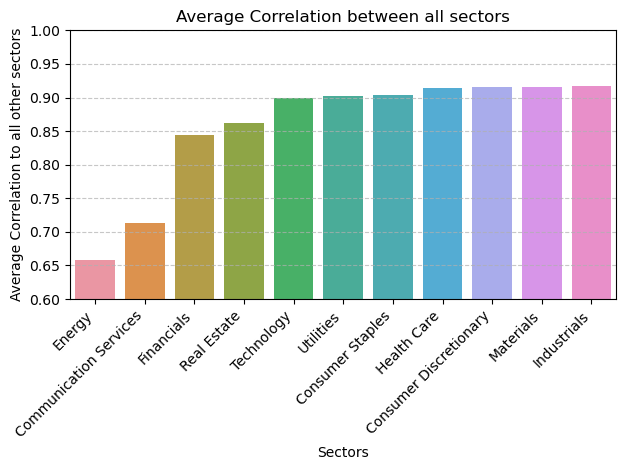

In [19]:
sns.barplot(x=[sectors_dict[x] for x in corrletion_df['sector']], y=corrletion_df['correlation'])
# Customize the plot
plt.title('Average Correlation between all sectors')
plt.xlabel('Sectors')
plt.ylabel('Average Correlation to all other sectors')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set custom y-axis limits to emphasize differences
plt.ylim(0.6, 1.0)

# Show the plot
plt.tight_layout()  # Ensure labels fit within the figure
plt.show()

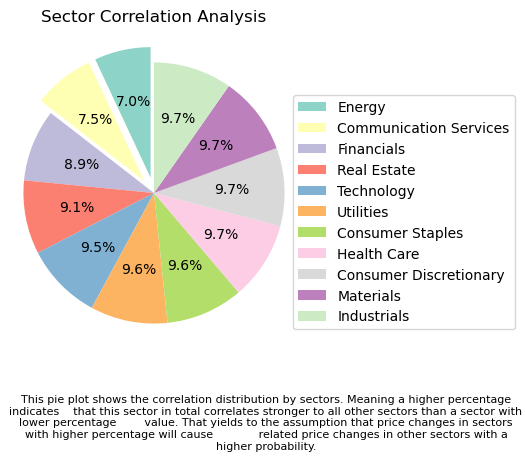

In [21]:
title = plt.title('Sector Correlation Analysis')
plt.gca().axis("equal")
pie = plt.pie(
    x=corrletion_df['correlation'], 
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set3'),
    # Add space around only one slice
    explode=[0.12, 0.12, 0, 0, 0, 0, 0, 0, 0, 0, 0],
)
plt.legend(pie[0], [sectors_dict[x] for x in corrletion_df['sector']], loc="center right",
           bbox_to_anchor=(0.8,0.5), bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.2, right=0.45)
#plt.savefig("sector_analysis.png", bbox_inches="tight")
txt="This pie plot shows the correlation distribution by sectors. Meaning a higher percentage indicates\
    that this sector in total correlates stronger to all other sectors than a sector with lower percentage\
        value. That yields to the assumption that price changes in sectors with higher percentage will cause\
             related price changes in other sectors with a higher probability."
plt.figtext(0.4, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=8)
plt.show()
